<a href="https://colab.research.google.com/github/nihalhabeeb/Retail-Sales-Prediction/blob/main/Retail_Sales_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Sales Prediction : Predicting sales of a major store chain Rossmann</u></b>

## <b> Problem Description </b>

### Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

## <b> Data Description </b>

### <b>Rossmann Stores Data.csv </b> - historical data including Sales
### <b>store.csv </b> - supplemental information about the stores


### <b><u>Data fields</u></b>
### Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* #### Id - an Id that represents a (Store, Date) duple within the test set
* #### Store - a unique Id for each store
* #### Sales - the turnover for any given day (this is what you are predicting)
* #### Customers - the number of customers on a given day
* #### Open - an indicator for whether the store was open: 0 = closed, 1 = open
* #### StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* #### SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* #### StoreType - differentiates between 4 different store models: a, b, c, d
* #### Assortment - describes an assortment level: a = basic, b = extra, c = extended
* #### CompetitionDistance - distance in meters to the nearest competitor store
* #### CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* #### Promo - indicates whether a store is running a promo on that day
* #### Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* #### Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* #### PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [4]:
#importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# file paths
file_path_1 = '/content/drive/MyDrive/AlmaBetter/Capstone Projects/Supervised ML- Regression/Rossmann Stores Data.csv'
file_path_2 = '/content/drive/MyDrive/AlmaBetter/Capstone Projects/Supervised ML- Regression/store.csv'

In [7]:
# Rossmann stores dataset
df = pd.read_csv('/content/drive/MyDrive/AlmaBetter/Retail Sales Prediction - Nihal Habeeb/Rossmann Stores Data.csv')
# store dataset
store_df = pd.read_csv('/content/drive/MyDrive/AlmaBetter/Retail Sales Prediction - Nihal Habeeb/store.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [8]:
# dataset with information by date for different stores
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [9]:
# dataset with information unique to each stores
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## Data cleaning

First let us start by handling the missing values in the store_df columns. **Note:** None of the rows can be removed as they contain unique information about each of the stores.

### Handling missing values: Store df

In [10]:
# checking if there are any duplicates of store information
store_df.Store.duplicated().sum()

0

In [11]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [12]:
# looking at the null values in CompetitionDistance
store_df[store_df['CompetitionDistance'].isna()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


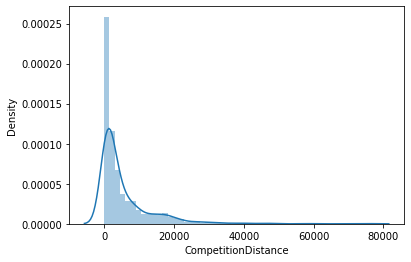

In [13]:
# the distribution of CompetitionDistance
sns.distplot(store_df['CompetitionDistance'])

In [14]:
# finding the minimum competition distance
store_df['CompetitionDistance'].min()

20.0

Before imputing a value to the null values of CompetitionDistance we need to understand if there is any role for CompetitionDistance in CompetitionOpenSinceMonth and CompetitionOpenSinceYear having null values (where CompetitionDistance null the other two columns are null as well).

In [15]:
# the data where CompetitionOpenSinceMonth is null
store_df[store_df['CompetitionOpenSinceMonth'].isna()].shape

(354, 10)

In [16]:
store_df.loc[(store_df['CompetitionOpenSinceMonth'].isna()) & (store_df['CompetitionOpenSinceYear'].isna())]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...
1095,1096,a,c,1130.0,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
1099,1100,a,a,540.0,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


We can see that CompetitionOpenSinceMonth and CompetitionOpenSinceYear have null values together always which makes sense as they both have information related to time of the competition.

Comparing the data where they are null and where they are not null, it seems like there is no relation between CompetitionDistance and these columns being null. Since there are large number of null values in these columns and they cannot be replaced meaningfully, they can be dropped completely.

Looking at the null values related to Promo (Promo2SinceWeek, Promo2SinceYear, PromoInterval)

In [17]:
# data where Promo2SinceWeek, Promo2SinceYear and PromoInterval are null
store_df.loc[(store_df['Promo2SinceWeek'].isna()) & (store_df['Promo2SinceYear'].isna()) & (store_df['PromoInterval'].isna())].shape

(544, 10)

In [18]:
# data where Promo2SinceWeek, Promo2SinceYear, PromoInterval and Promo2 are null
store_df.loc[(store_df['Promo2SinceWeek'].isna()) & (store_df['Promo2SinceYear'].isna()) & (store_df['PromoInterval'].isna()) & (store_df['Promo2'] == 0)].shape

(544, 10)

We know there are 571 non null values (hence 544 null values) for each columns, and from the dataset shapes above we can see that these 3 columns have null values only when Promo2 is zero i.e there is no promotion. This makes sense as these columns don't have any information to provide if the store doesn't have Promo2.

For now, we can remove these columns as the null values cannot be replaced meaningfully.

In [19]:
# dropping columns with missing values
store_df.drop(columns=['CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2SinceWeek','Promo2SinceYear','PromoInterval'], axis=1, inplace = True)

In [20]:
# imputing mean CompetitionDistance values for the three null values
store_df.loc[store_df['CompetitionDistance'].isna(),'CompetitionDistance'] = round(store_df['CompetitionDistance'].mean(),1)

In [21]:
store_df.loc[store_df['CompetitionDistance'].isna(),]

,Store,StoreType,Assortment,CompetitionDistance,Promo2


In [22]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Store                1115 non-null   int64  
 1   StoreType            1115 non-null   object 
 2   Assortment           1115 non-null   object 
 3   CompetitionDistance  1115 non-null   float64
 4   Promo2               1115 non-null   int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 43.7+ KB


### Handling missing values: df table

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


There are no null values in this dataframe.

## Joining Dataframes

In [24]:
## joining the two tables
joined_df = pd.merge(df, store_df, how = 'left')

In [25]:
joined_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,0


In [26]:
joined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 13 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   Store                1017209 non-null  int64  
 1   DayOfWeek            1017209 non-null  int64  
 2   Date                 1017209 non-null  object 
 3   Sales                1017209 non-null  int64  
 4   Customers            1017209 non-null  int64  
 5   Open                 1017209 non-null  int64  
 6   Promo                1017209 non-null  int64  
 7   StateHoliday         1017209 non-null  object 
 8   SchoolHoliday        1017209 non-null  int64  
 9   StoreType            1017209 non-null  object 
 10  Assortment           1017209 non-null  object 
 11  CompetitionDistance  1017209 non-null  float64
 12  Promo2               1017209 non-null  int64  
dtypes: float64(1), int64(8), object(4)
memory usage: 108.6+ MB


All the missing values were handled earlier before joining the tables.

## Exploratory Data Analysis

In [27]:
# descriptive statistics
joined_df.describe(include = 'all')

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2
count,1.017209e+06,1.017209e+06,1017209,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1017209,1.017209e+06,1017209,1017209,1.017209e+06,1.017209e+06
unique,NaN,NaN,942,NaN,NaN,NaN,NaN,5,NaN,4,3,NaN,NaN
top,NaN,NaN,2015-07-31,NaN,NaN,NaN,NaN,0,NaN,a,a,NaN,NaN
freq,NaN,NaN,1115,NaN,NaN,NaN,NaN,855087,NaN,551627,537445,NaN,NaN
mean,5.584297e+02,3.998341e+00,NaN,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,NaN,1.786467e-01,NaN,NaN,5.430020e+03,5.005638e-01
std,3.219087e+02,1.997391e+00,NaN,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,NaN,3.830564e-01,NaN,NaN,7.705298e+03,4.999999e-01
min,1.000000e+00,1.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00,NaN,NaN,2.000000e+01,0.000000e+00
25%,2.800000e+02,2.000000e+00,NaN,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,NaN,0.000000e+00,NaN,NaN,7.100000e+02,0.000000e+00
50%,5.580000e+02,4.000000e+00,NaN,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,NaN,0.000000e+00,NaN,NaN,2.330000e+03,1.000000e+00
75%,8.380000e+02,6.000000e+00,NaN,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,NaN,0.000000e+00,NaN,NaN,6.880000e+03,1.000000e+00


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


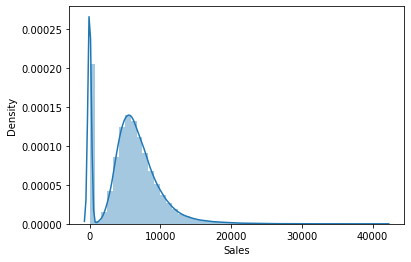

In [28]:
# distribution plot
sns.distplot(joined_df['Sales'])

The distribution is close to normal, but we can see a huge spike close to zero. This is because the data contains a lot of entries where the store was closed. Obviously, the total sales will be zero for such data. We can ignore the data where store is closed as it doesn't help in predicting the sales.

In [29]:
# only keeping the data where store is open
openstores_df = joined_df[joined_df['Open'] != 0]

In [30]:
openstores_df.shape

(844392, 13)

In [31]:
joined_df.shape

(1017209, 13)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


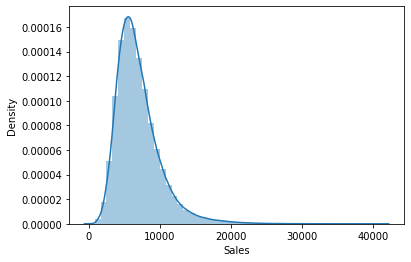

In [32]:
# distribution of sales
sns.distplot(openstores_df['Sales'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


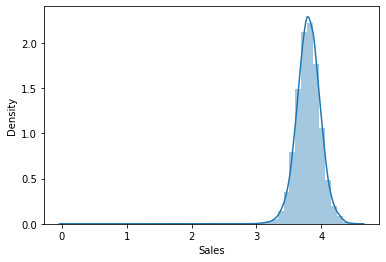

In [33]:
# distribution of log transformation of sales
sns.distplot(np.log10(openstores_df['Sales']+1))

While taking log transformation of Sales, the data containing 0 Sales will be a problem as log(0) is infinity. So they are replaced with a close non zero value. We will also have to do the same for customers, as sales with 0 value could be linked with customers column with 0 values as well.

In [34]:
# making copy of the dataset
dataset = openstores_df.copy()

In [35]:
# replacing 0 sales values with 0.5
dataset.loc[dataset['Sales'] == 0,'Sales'] = 0.5
dataset.loc[dataset['Customers'] == 0,'Customers'] = 0.5

In [36]:
# drop Open column as we only included data with Open = 1 making the column redundant
dataset.drop('Open', axis = 1, inplace = True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


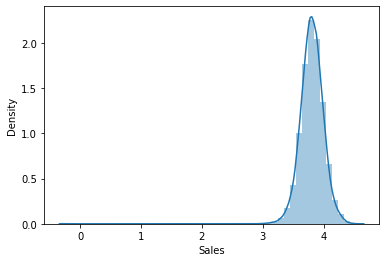

In [37]:
# log transformation of sales
sns.distplot(np.log10(dataset['Sales']))

### Relationship with numerical variables

In [38]:
# list of all the numerical features
numerical_features = list(dataset.describe().columns)
# remove Store (which is just an ID of each stores)
numerical_features.remove('Store')
# remove dependent variable (Sales)
numerical_features.remove('Sales')
numerical_features

['DayOfWeek',
 'Customers',
 'Promo',
 'SchoolHoliday',
 'CompetitionDistance',
 'Promo2']

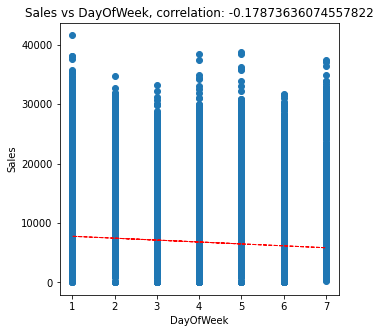

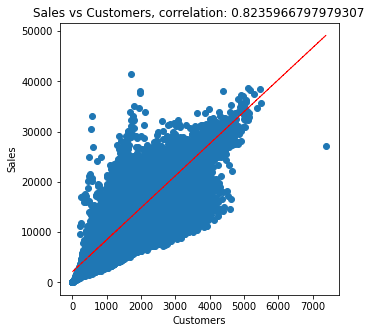

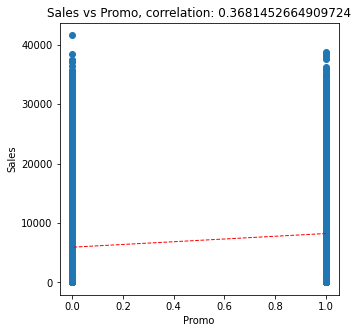

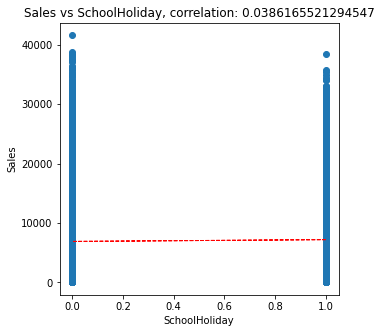

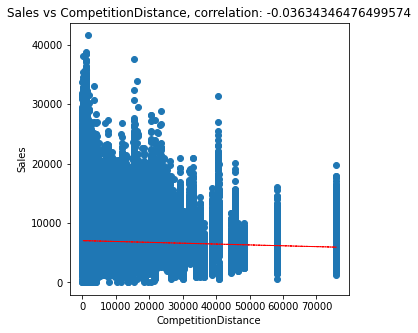

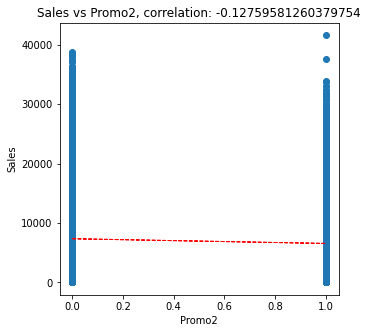

In [39]:
# plotting the relationship between each numerical features and the Sales variable
for col in numerical_features:
  fig = plt.figure(figsize = (5,5))
  feature = dataset[col]
  label = dataset['Sales']
  # correlation coefficient
  correlation = feature.corr(label)
  # plot
  plt.scatter(feature,label)
  plt.xlabel(col)
  plt.ylabel('Sales')
  plt.title('Sales vs '+col+', correlation: '+ str(correlation))
  # getting best fit line for each relationship
  slope, intercept = np.polyfit(feature, label, 1)
  plt.plot(feature, slope*feature + intercept, "r--", lw = 1)
plt.show()

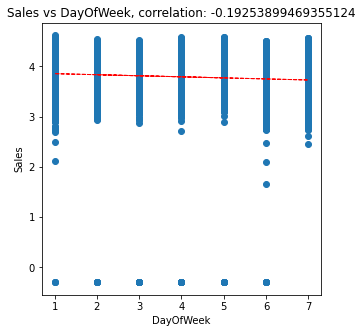

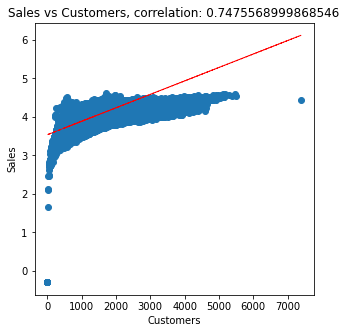

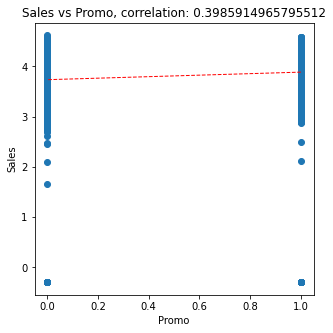

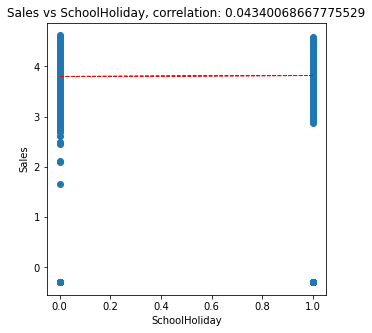

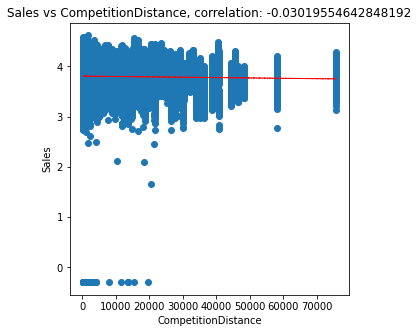

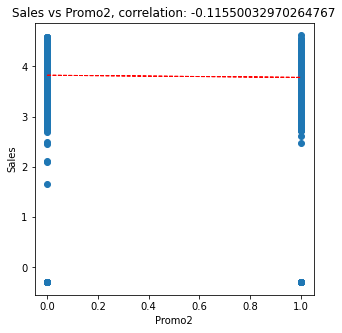

In [40]:
# plotting the relationship between features and log transformation of Sales variable
for col in numerical_features:
  fig = plt.figure(figsize = (5,5))
  feature = dataset[col]
  label = np.log10(dataset['Sales'])
  # correlation coefficient
  correlation = feature.corr(label)
  # plot
  plt.scatter(feature,label)
  plt.xlabel(col)
  plt.ylabel('Sales')
  plt.title('Sales vs '+col+', correlation: '+ str(correlation))
  # getting best fit line for each relationship
  slope, intercept = np.polyfit(feature, label, 1)
  plt.plot(feature, slope*feature + intercept, "r--", lw = 1)
plt.show()

The relationship between Customers and log tansformation of Sales variable is not linear. Let us look at the relationship between log of both variables.

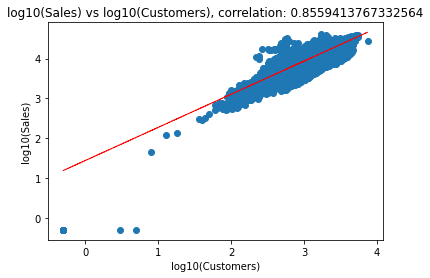

In [41]:
feature = np.log10(dataset['Customers'])
label = np.log10(dataset['Sales'])
# correlation coefficient
correlation = feature.corr(label)
plt.scatter(feature, label)
plt.xlabel('log10(Customers)')
plt.ylabel('log10(Sales)')
plt.title('log10(Sales) vs log10(Customers), correlation: '+ str(correlation))
# getting best fit line for each relationship
slope, intercept = np.polyfit(feature, label, 1)
plt.plot(feature, slope*feature + intercept, "r--", lw = 1)

So we will create a log10(Customers) column

In [42]:
# log transformation of customers
dataset['Log_Customers'] = np.log10(dataset['Customers'])

In [43]:
dataset.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,Log_Customers
0,1,5,2015-07-31,5263.0,555.0,1,0,1,c,a,1270.0,0,2.744293
1,2,5,2015-07-31,6064.0,625.0,1,0,1,a,a,570.0,1,2.795880
2,3,5,2015-07-31,8314.0,821.0,1,0,1,a,a,14130.0,1,2.914343
3,4,5,2015-07-31,13995.0,1498.0,1,0,1,c,c,620.0,0,3.175512
4,5,5,2015-07-31,4822.0,559.0,1,0,1,a,a,29910.0,0,2.747412


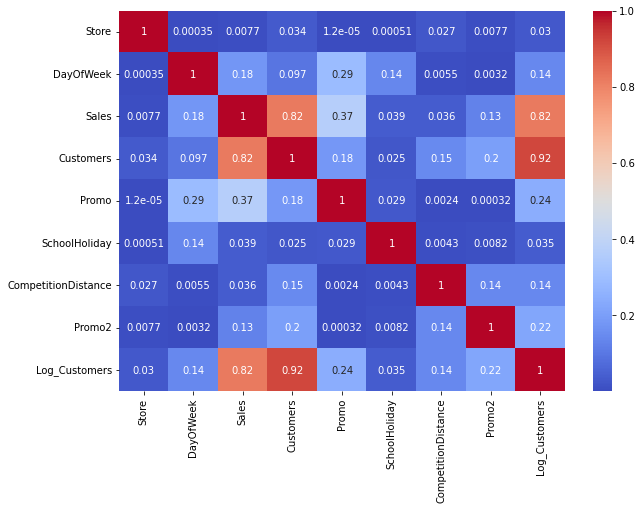

In [44]:
# heat map
plt.figure(figsize = (10,7))
correlation = dataset.corr()
sns.heatmap(abs(correlation), annot = True, cmap = 'coolwarm')

We do not find any multicollinearity between the dependent variables except for Customers and Log(Customers) for obvious reasons. Only the log transformation will be used in the model. We can see good correlation between customers variable and sales variable.

Variance Inflation Factor (VIF)

In [45]:
# Checking for multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calculate_vif(X):

    # VIF calculation
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [46]:
calculate_vif(dataset[numerical_features])

,variables,VIF
0,DayOfWeek,3.229168
1,Customers,3.358126
2,Promo,1.853215
3,SchoolHoliday,1.214039
4,CompetitionDistance,1.411571
5,Promo2,1.779197


Since all the variables have low VIF and did not show high correlation between them we decide to not drop any of them (**Note**: we will only be using log transformation of customers instead of customers column.

### Relationship with Non numerical variables

In [47]:
dataset.describe(include = 'object')

,Date,StateHoliday,StoreType,Assortment
count,844392,844392,844392,844392
unique,942,5,4,3
top,2014-04-16,0,a,a
freq,1115,731342,457077,444909


In [48]:
from datetime import datetime

# converting the string date values to datetime format
dataset['Date'] = dataset['Date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))

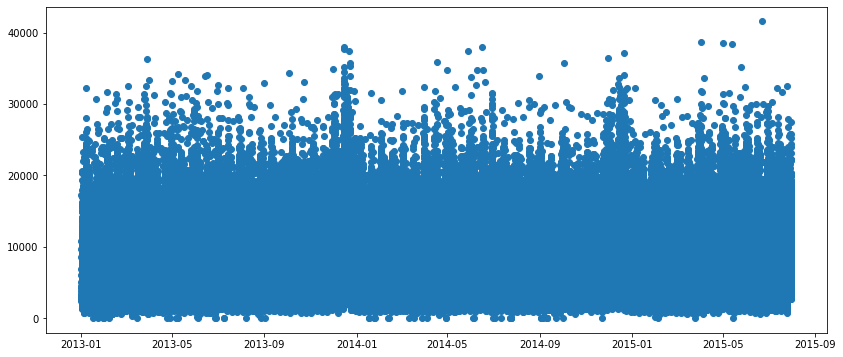

In [49]:
# relation between date and sales
plt.figure(figsize = (14,6))
plt.scatter(dataset['Date'],dataset['Sales'])

In [50]:
# creating year column
dataset['Year'] = dataset['Date'].apply(lambda x: x.year)
# creating month column
dataset['Month'] = dataset['Date'].apply(lambda x: x.month)

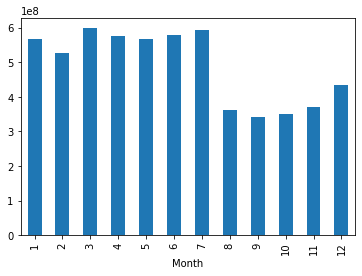

In [51]:
# total sales in each month
dataset.groupby('Month')['Sales'].sum().plot(kind = 'bar')

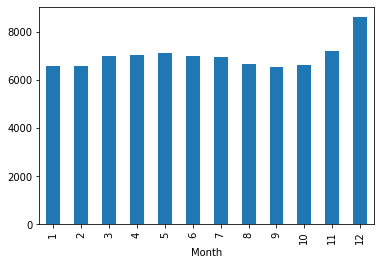

In [52]:
# average sales in each month
dataset.groupby('Month')['Sales'].mean().plot(kind = 'bar')

In [53]:
# average sales in each year
dataset.groupby('Year')['Sales'].mean()

Year
2013    6814.392053
2014    7025.404253
2015    7088.126655
Name: Sales, dtype: float64

One of the columns retrieved from the date data, either year or month, can be used in the model. We cannot use both the columns as they will be highly correlated.

Looking at the State Holiday column.

In [54]:
# distribution of StateHoliday column across the categories
dataset['StateHoliday'].value_counts()

0    731342
0    112140
a       694
b       145
c        71
Name: StateHoliday, dtype: int64

In [55]:
# shape of dataset where values are 0 (integer)
dataset[dataset['StateHoliday'] == 0].shape

(112140, 15)

In [56]:
# shape of dataset where values are 0 (string)
dataset[dataset['StateHoliday'] == '0'].shape

(731342, 15)

We can spot something unusual here. There are two 'zero' categories. One of them is integer while the other one is string ('0'). Since the rest of the categories are strings we can convert the integer 0 to string.

In [57]:
# replacing the integer 0 to '0'
dataset.loc[dataset['StateHoliday'] == 0, 'StateHoliday'] = '0'

In [58]:
# checking value counts again
dataset['StateHoliday'].value_counts()

0    843482
a       694
b       145
c        71
Name: StateHoliday, dtype: int64

Looking at StoreType data.

In [59]:
# distribution of StoreType data
dataset['StoreType'].value_counts()

a    457077
d    258774
c    112978
b     15563
Name: StoreType, dtype: int64

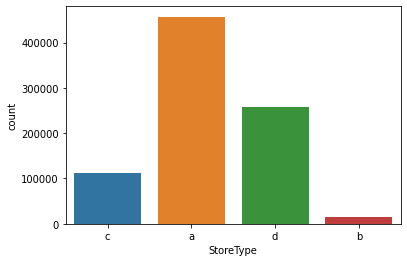

In [60]:
# countplot of StoreType data
sns.countplot(x = 'StoreType', data = dataset)

Looking at Assortment data.

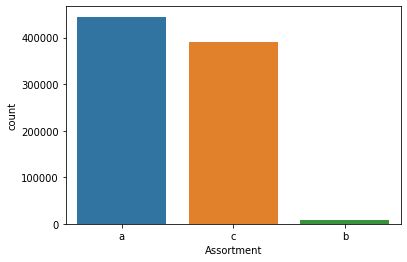

In [61]:
# distribution of Assortment data
sns.countplot(x = 'Assortment', data = dataset)